# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
#importing the required libraries
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sqlite3
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.linalg import eigh
import re
from gensim.models import word2vec
import pickle
from gensim.models import KeyedVectors
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn import decomposition
pca = decomposition.PCA()
from sklearn.manifold import TSNE
from scipy.sparse import csc_matrix
from scipy.sparse import csr_matrix
from tqdm import tqdm
import string
from sklearn.cross_validation import train_test_split
from sklearn import linear_model 
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.model_selection import TimeSeriesSplit
from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import TruncatedSVD
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC

/home/blurryface/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/blurryface/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
#loading the data through sqlite and preprocesing it a little bit.
temp = sqlite3.connect('database.sqlite')
temp = pd.read_sql_query("""SELECT * FROM Reviews WHERE SCORE != 3""", temp)
def partiton(x):
    if x > 3:
        return 'positive'
    else:
        return 'negative'
score = temp['Score']
positive_negative = score.map(partiton)
temp['Score'] = positive_negative

In [4]:
#sorting the data in ascending order according to the time stamp
temp.sort_values('Time', inplace=True)
temp.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
212472,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", sqlite3.connect('database.sqlite'))
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [5]:
#getting rid of the duplicates
final = temp.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
#Removing all the points where Denominator < Numerator
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...


In [7]:
final.shape

(364171, 10)

In [8]:
#Taking top 60k values for the assignment
final = final.iloc[0: 60000,:]

In [9]:
final.shape

(60000, 10)

# Text Preprocessing: Stemming, stop-word removal and Lemmatization.

In [2]:
stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')
def clean_html(sentence):
    clean = re.compile('<.*?>')
    cleantext = re.sub(clean, ' ', sentence)
    return cleantext
def clean_punctuation(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned

In [ ]:
i=0
strl = ' '
final_string = []
all_positive_words = []
all_negative_words = []
s = ''
for sent in final['Text'].values:
    sent = clean_html(sent)
    filtered_sentence = []
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if ((cleaned_words.isalpha()) & (len(cleaned_words) > 2)):
                if (cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) 
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) 
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) 
    
    final_string.append(str1)
    i+=1

In [ ]:
final['CleanedText']=final_string 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [ ]:
final.head(3)
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)
final.head()

In [ ]:
#Saving the cleaned data for future assignments
clean_data = open("clean_data_1.pickle", "wb")
pickle.dump(final, clean_data)
clean_data.close()

In [3]:
pickle_in = open("clean_data_1.pickle", "rb")
final = pickle.load(pickle_in)

In [3]:
final.shape

(60000, 12)

In [4]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedSummary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educ
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,whole seri great way spend time child
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,entertainingl funni
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,modern day fairi tale
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,fantast


In [5]:
#Saving the score values in a diffrent list and processing it for train, cv and test data
scores = final['Score'].get_values()
li = lambda x: 1 if x=='positive'  else 0
final_scores = []
for i in range(0,60000):
    final_scores.append(li(scores[i]))
final_scores = np.asarray(final_scores)
final_scores.shape

(60000,)

# Dividing the whole data into train, cross-validation and test sets

In [6]:
#train data
X_train = final[0: 40000]
Y_train = final_scores[0: 40000]
print(X_train.shape)
print(Y_train.shape)

(40000, 12)
(40000,)


In [7]:
#CV data
X_CV = final[40000: 50000]
Y_CV = final_scores[40000: 50000]
print(X_CV.shape)
print(Y_CV.shape)

(10000, 12)
(10000,)


In [8]:
#test data
X_test = final[50000: ]
Y_test = final_scores[50000: ]
print(X_test.shape)
print(Y_test.shape)

(10000, 12)
(10000,)


# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# 1:- Linear SVM

# BOW

In [9]:
count_vect = CountVectorizer(max_features=2000, min_df=10)
X_train_bow = count_vect.fit_transform(X_train['CleanedText'].values)
X_train_bow.shape

(40000, 2000)

In [10]:
train_bow = open("train_bow.pickle", "wb")
pickle.dump(X_train_bow, train_bow)
train_bow.close()

In [11]:
X_CV_bow = count_vect.transform(X_CV['CleanedText'].values)
X_CV_bow.shape

(10000, 2000)

In [12]:
CV_bow = open("CV_bow.pickle", "wb")
pickle.dump(X_CV_bow, CV_bow)
CV_bow.close()

In [13]:
X_test_bow = count_vect.transform(X_test['CleanedText'].values)
X_test_bow.shape

(10000, 2000)

In [14]:
test_bow = open("test_bow.pickle", "wb")
pickle.dump(X_test_bow, test_bow)
test_bow.close()

# Linear SVM on BOW

In [17]:
tuned_parameters = [{'alpha' : [10**-4, 10**-3, 10**-2, 10**-1, 10, 10**2, 10**3, 10**4], 'penalty' : ['l1', 'l2']}]
model = GridSearchCV(linear_model.SGDClassifier(loss='hinge', fit_intercept=False, max_iter=1000, tol=1e-3, class_weight={1: 1, 0: 5.3}), tuned_parameters, scoring = 'roc_auc')
model.fit(X_train_bow, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight={1: 1, 0: 5.3},
       epsilon=0.1, eta0=0.0, fit_intercept=False, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=0.001, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'alpha': [0.0001, 0.001, 0.01, 0.1, 10, 100, 1000, 10000], 'penalty': ['l1', 'l2']}],
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

### From above it can be seen that best penalty would be l2, thus using l2 penalty now we will get the train and CV scores

In [18]:
def scores(X, Y):
    alphas = [10**-4, 10**-3, 10**-2, 10**-1, 10, 10**2, 10**3, 10**4]
    scores = []
    for alpha in alphas:
            clf = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=alpha, fit_intercept=False, max_iter=1000, tol=1e-3, class_weight={1: 1, 0: 5.3})
            clf_sigmoid = CalibratedClassifierCV(clf, cv=2, method='sigmoid')
            clf_sigmoid.fit(X_train_bow, Y_train)
            pred = clf_sigmoid.predict(X)
            auc = roc_auc_score(Y, pred)
            scores.append(auc)
    return scores

In [19]:
train_scores = scores(X_train_bow, Y_train)

In [20]:
cv_scores = scores(X_CV_bow, Y_CV)

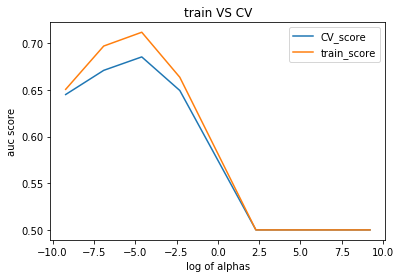

In [21]:
alphas = [10**-4, 10**-3, 10**-2, 10**-1, 10, 10**2, 10**3, 10**4]
log_alphas = np.log(np.asarray(alphas))
plt.plot(log_alphas, cv_scores, label='CV_score')
plt.plot(log_alphas, train_scores, label='train_score')
plt.title('train VS CV')
plt.ylabel('auc score')
plt.xlabel('log of alphas')
plt.legend()
plt.show()

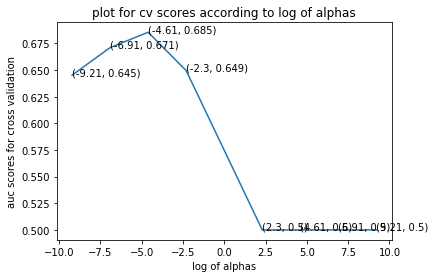

The auc score for each alpha value for cross validation is :  [0.645 0.671 0.685 0.649 0.5   0.5   0.5   0.5  ]


In [22]:
plt.plot(log_alphas, cv_scores )

plt.title('plot for cv scores according to log of alphas')
for xy in zip(np.round(log_alphas, 2), np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log of alphas')
plt.ylabel('auc scores for cross validation')
plt.show()

print("The auc score for each alpha value for cross validation is : ", np.round(cv_scores,3))

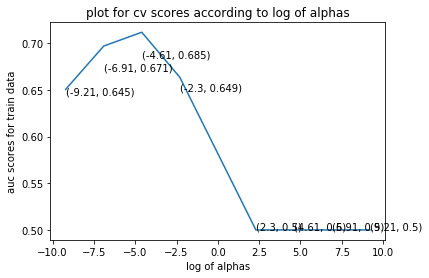

The auc score for each alpha value for train data is :  [0.651 0.697 0.712 0.664 0.5   0.5   0.5   0.5  ]


In [23]:
plt.plot(log_alphas, train_scores )

plt.title('plot for cv scores according to log of alphas')
for xy in zip(np.round(log_alphas, 2), np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log of alphas')
plt.ylabel('auc scores for train data')
plt.show()

print("The auc score for each alpha value for train data is : ", np.round(train_scores,3))

In [24]:
optimal_alpha_for_cv = alphas[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of alpha for cv is {} and it\'s value is {}'.format(optimal_alpha_for_cv, max(cv_scores)))


The optimal value of alpha for cv is 0.01 and it's value is 0.6854837743265267


In [25]:
optimal_alpha_for_train = alphas[train_scores.index(max(train_scores))]
print('\nThe optimal value of alpha for training is {} and it\'s value is {}'.format(optimal_alpha_for_train, max(train_scores)))


The optimal value of alpha for training is 0.01 and it's value is 0.7119276231585527


In [26]:
x = PrettyTable()
x.field_names = ['alphas for cv', 'cv score', 'alphas for train', 'train score']
for z, y in zip(sorted(cv_scores, reverse=True), sorted(train_scores, reverse=True)):
    x.add_row([alphas[cv_scores.index(z)], z, alphas[train_scores.index(y)], y])
print(x)

+---------------+--------------------+------------------+--------------------+
| alphas for cv |      cv score      | alphas for train |    train score     |
+---------------+--------------------+------------------+--------------------+
|      0.01     | 0.6854837743265267 |       0.01       | 0.7119276231585527 |
|     0.001     | 0.6710728537532356 |      0.001       | 0.6971255582050585 |
|      0.1      | 0.6494703288275334 |       0.1        | 0.6636472354602274 |
|     0.0001    | 0.645161507765315  |      0.0001      | 0.6507113669708283 |
|       10      |        0.5         |        10        |        0.5         |
|       10      |        0.5         |        10        |        0.5         |
|       10      |        0.5         |        10        |        0.5         |
|       10      |        0.5         |        10        |        0.5         |
+---------------+--------------------+------------------+--------------------+


### Based on the above graphs and the table we can choose the optimal value of alpha to be equal to 0.01

In [34]:
SVM_optimal = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=0.01, fit_intercept=False, max_iter=1000, tol=1e-3, class_weight={1: 1, 0: 5.3})

# fitting the model
SVM_optimal.fit(X_train_bow, Y_train)

# predict the response
pred = SVM_optimal.predict(X_test_bow)

# evaluate auc_score
auc_score = roc_auc_score(Y_test, pred)

In [35]:
print('\nThe auc score for test data for alpha = {} is {:2f}'.format(0.01, auc_score))


The auc score for test data for alpha = 0.01 is 0.820727


In [36]:
conf_matrix = confusion_matrix(Y_test, pred)
conf_matrix

array([[ 896,  334],
       [ 763, 8007]])

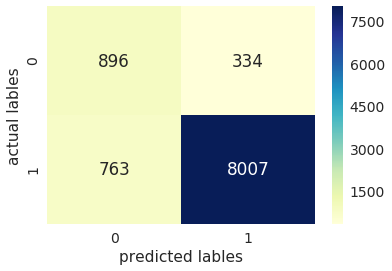

In [37]:
df_cm = pd.DataFrame(conf_matrix, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
plt.xlabel('predicted lables')
plt.ylabel('actual lables')
plt.show()

In [38]:
print(classification_report(Y_test, pred))

             precision    recall  f1-score   support

          0       0.54      0.73      0.62      1230
          1       0.96      0.91      0.94      8770

avg / total       0.91      0.89      0.90     10000



## Top 20 features for positive class and top 20 features for negative class

In [1]:
def show_most_informative_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.feature_importances_, feature_names))
    top = coefs_with_fns[:-(n + 1):-1]
    print("Top 10 Features:")
    for (coef_1, fn_1) in top:
        print("")
        print("%-15s" % (fn_1))

In [40]:
show_(count_vect, SVM_optimal.coef_, 20)

These are the top 20 important Features Which are most widely used in Positive and Negative Reviews:


Positive: 				 Negative:


(0.30028376399179835, 'satisfi') 		 (-0.7858310489729974, 'disappoint')
(0.3071581061435359, 'rich') 		 (-0.6094729257710957, 'worst')
(0.3079080343782713, 'glad') 		 (-0.5197315136811453, 'bland')
(0.30834549251519006, 'alway') 		 (-0.48842200988095485, 'horribl')
(0.32762489754984503, 'yummi') 		 (-0.474517090528584, 'unfortun')
(0.32918724803886823, 'easi') 		 (-0.4717673536678811, 'terribl')
(0.3368427654351219, 'thank') 		 (-0.43117748796284827, 'aw')
(0.347466748760526, 'keep') 		 (-0.40433630656131986, 'bad')
(0.37380797800560733, 'addict') 		 (-0.3948997096075566, 'money')
(0.3751203524163903, 'amaz') 		 (-0.3936810762261, 'weak')
(0.38727543922103747, 'tasti') 		 (-0.3900876701013279, 'return')
(0.43508336418538573, 'favorit') 		 (-0.3808698022160427, 'sorri')
(0.4513943032908679, 'wonder') 		 (-0.37671394991522833, 'mayb')
(0.5060765704069585, 'nic

# TF-IDF

In [9]:
tf_idf_vect = TfidfVectorizer(max_features=2000)
X_train_tfidf = tf_idf_vect.fit_transform(X_train['CleanedText'].values)
X_train_tfidf.shape

(40000, 2000)

In [10]:
X_CV_tfidf = tf_idf_vect.transform(X_CV['CleanedText'].values)
X_CV_tfidf.shape

(10000, 2000)

In [11]:
X_test_tfidf = tf_idf_vect.transform(X_test['CleanedText'].values)
X_test_tfidf.shape

(10000, 2000)

## Linear SVM on TF-IDF

In [12]:
tuned_parameters = [{'alpha' : [10**-4, 10**-3, 10**-2, 10**-1, 10, 10**2, 10**3, 10**4], 'penalty' : ['l1', 'l2']}]
model = GridSearchCV(linear_model.SGDClassifier(loss='hinge', fit_intercept=False, max_iter=1000, tol=1e-3, class_weight={1: 1, 0: 5.3}), tuned_parameters, scoring = 'roc_auc')
model.fit(X_train_tfidf, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight={1: 1, 0: 5.3},
       epsilon=0.1, eta0=0.0, fit_intercept=False, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=0.001, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'alpha': [0.0001, 0.001, 0.01, 0.1, 10, 100, 1000, 10000], 'penalty': ['l1', 'l2']}],
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

### From above it can be seen that best penalty would be l2, thus using l2 penalty now we will get the train and CV scores

In [15]:
def scores(X, Y):
    alphas = [10**-4, 10**-3, 10**-2, 10**-1, 10, 10**2, 10**3, 10**4]
    scores = []
    for alpha in alphas:
            clf = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=alpha, fit_intercept=False, max_iter=1000, tol=1e-3, class_weight={1: 1, 0: 5.3})
            clf_sigmoid = CalibratedClassifierCV(clf, cv=2, method='sigmoid')
            clf_sigmoid.fit(X_train_tfidf, Y_train)
            pred = clf_sigmoid.predict(X)
            auc = roc_auc_score(Y, pred)
            scores.append(auc)
    return scores

In [16]:
train_scores = scores(X_train_tfidf, Y_train)

In [17]:
cv_scores = scores(X_CV_tfidf, Y_CV)

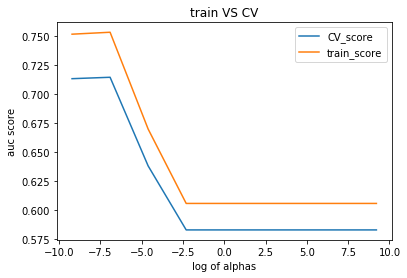

In [18]:
alphas = [10**-4, 10**-3, 10**-2, 10**-1, 10, 10**2, 10**3, 10**4]
log_alphas = np.log(np.asarray(alphas))
plt.plot(log_alphas, cv_scores, label='CV_score')
plt.plot(log_alphas, train_scores, label='train_score')
plt.title('train VS CV')
plt.ylabel('auc score')
plt.xlabel('log of alphas')
plt.legend()
plt.show()

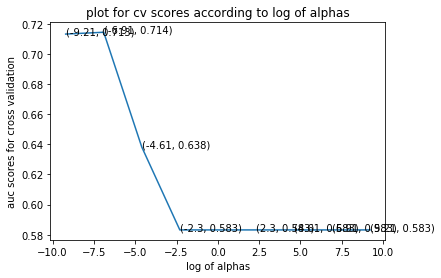

The auc score for each alpha value for cross validation is :  [0.713 0.714 0.638 0.583 0.583 0.583 0.583 0.583]


In [19]:
plt.plot(log_alphas, cv_scores )

plt.title('plot for cv scores according to log of alphas')
for xy in zip(np.round(log_alphas, 2), np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log of alphas')
plt.ylabel('auc scores for cross validation')
plt.show()

print("The auc score for each alpha value for cross validation is : ", np.round(cv_scores,3))

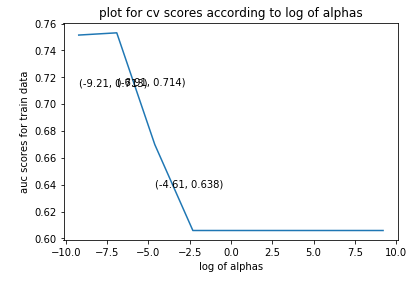

The auc score for each alpha value for train data is :  [0.751 0.753 0.67  0.606 0.606 0.606 0.606 0.606]


In [20]:
plt.plot(log_alphas, train_scores )

plt.title('plot for cv scores according to log of alphas')
for xy in zip(np.round(log_alphas, 2), np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log of alphas')
plt.ylabel('auc scores for train data')
plt.show()

print("The auc score for each alpha value for train data is : ", np.round(train_scores,3))

In [21]:
optimal_alpha_for_cv = alphas[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of alpha for cv is {} and it\'s value is {}'.format(optimal_alpha_for_cv, max(cv_scores)))


The optimal value of alpha for cv is 0.001 and it's value is 0.7143745206595724


In [22]:
optimal_alpha_for_train = alphas[train_scores.index(max(train_scores))]
print('\nThe optimal value of alpha for training is {} and it\'s value is {}'.format(optimal_alpha_for_train, max(train_scores)))


The optimal value of alpha for training is 0.001 and it's value is 0.7530773959239185


In [23]:
x = PrettyTable()
x.field_names = ['alphas for cv', 'cv score', 'alphas for train', 'train score']
for z, y in zip(sorted(cv_scores, reverse=True), sorted(train_scores, reverse=True)):
    x.add_row([alphas[cv_scores.index(z)], z, alphas[train_scores.index(y)], y])
print(x)

+---------------+--------------------+------------------+--------------------+
| alphas for cv |      cv score      | alphas for train |    train score     |
+---------------+--------------------+------------------+--------------------+
|     0.001     | 0.7143745206595724 |      0.001       | 0.7530773959239185 |
|     0.0001    | 0.7131596922634456 |      0.0001      | 0.7514113386286969 |
|      0.01     | 0.6381975901160004 |       0.01       | 0.6698807798891115 |
|      0.1      | 0.5831678110919375 |       0.1        | 0.6059329063072963 |
|      0.1      | 0.5831678110919375 |       0.1        | 0.6059329063072963 |
|      0.1      | 0.5831678110919375 |       0.1        | 0.6059329063072963 |
|      0.1      | 0.5831678110919375 |       0.1        | 0.6059329063072963 |
|      0.1      | 0.5831678110919375 |       0.1        | 0.6059329063072963 |
+---------------+--------------------+------------------+--------------------+


### Based on the above graphs and the table we can choose the optimal value of alpha to be equal to 0.001

In [24]:
SVM_optimal = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=0.001, fit_intercept=False, max_iter=1000, tol=1e-3, class_weight={1: 1, 0: 5.3})

# fitting the model
SVM_optimal.fit(X_train_tfidf, Y_train)

# predict the response
pred = SVM_optimal.predict(X_test_tfidf)

# evaluate auc_score
auc_score = roc_auc_score(Y_test, pred)

In [25]:
print('\nThe auc score for test data for alpha = {} is {:2f}'.format(0.001, auc_score))


The auc score for test data for alpha = 0.001 is 0.801473


In [26]:
conf_matrix = confusion_matrix(Y_test, pred)
conf_matrix

array([[ 829,  401],
       [ 623, 8147]])

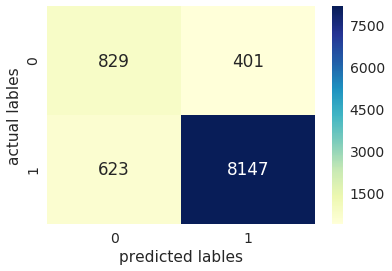

In [27]:
df_cm = pd.DataFrame(conf_matrix, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
plt.xlabel('predicted lables')
plt.ylabel('actual lables')
plt.show()

In [28]:
print(classification_report(Y_test, pred))

             precision    recall  f1-score   support

          0       0.57      0.67      0.62      1230
          1       0.95      0.93      0.94      8770

avg / total       0.91      0.90      0.90     10000



## Top 20 features for positive class and top 20 features for negative class

In [29]:
def getImpFeatures(vectorizer,w_vec,top_n_features):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(w_vec[0], feature_names))
    print("These are the top 20 important Features Which are most widely used in Positive and Negative Reviews:")
    pos_features = coefs_with_fns[len(feature_names)-top_n_features:len(feature_names)];
    neg_features = coefs_with_fns[0:top_n_features];
    print("\n")
    print("Positive: \t\t\t\t Negative:")
    print("\n")
    for i in range(20):
        print(pos_features[i],"\t\t",neg_features[i])

In [30]:
getImpFeatures(tf_idf_vect, SVM_optimal.coef_, 20)

These are the top 20 important Features Which are most widely used in Positive and Negative Reviews:


Positive: 				 Negative:


(1.1630264412207343, 'thank') 		 (-2.9693043061436244, 'disappoint')
(1.1880139869497226, 'alway') 		 (-2.021437789483411, 'worst')
(1.2013655718168816, 'easi') 		 (-1.799721213498545, 'horribl')
(1.2108827971997729, 'quick') 		 (-1.7732058214465767, 'terribl')
(1.2120152640251873, 'enjoy') 		 (-1.7576678941718462, 'bad')
(1.2328598555436683, 'amaz') 		 (-1.6745337077611144, 'bland')
(1.3519784444831622, 'tasti') 		 (-1.6536900885395212, 'mayb')
(1.44276270667265, 'find') 		 (-1.579473197854206, 'unfortun')
(1.4476104758296184, 'keep') 		 (-1.553825232975931, 'aw')
(1.4655017904047225, 'use') 		 (-1.5089208263851064, 'didnt')
(1.6393060837459614, 'wonder') 		 (-1.49793840180492, 'thought')
(1.6531089949547857, 'favorit') 		 (-1.4864166728860044, 'money')
(1.7848077650789096, 'nice') 		 (-1.437034591672996, 'return')
(1.870345192992376, 'perfect') 		 (-1.4187

# W2V

In [10]:
i=0
list_of_sent =[]
for sent in X_train['Text'].values:
    filtered_sentence =[]
    sent = clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sent.append(filtered_sentence)

In [11]:
w2v_model=Word2Vec(list_of_sent, min_count=5 ,size=50)

In [12]:
w2v_words = list(w2v_model.wv.vocab)

# Average W2V

In [13]:
X_train_avgw2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_train_avgw2v.append(sent_vec)
print(len(X_train_avgw2v))
print(len(X_train_avgw2v[0]))

100%|██████████| 40000/40000 [01:33<00:00, 427.98it/s]

40000
50


In [14]:
X_train_avgw2v = np.asarray(X_train_avgw2v)

In [15]:
X_train_avgw2v = StandardScaler().fit_transform(X_train_avgw2v)

In [16]:
train_w2v = open("train_w2v.pickle", "wb")
pickle.dump(X_train_avgw2v, train_w2v)
train_w2v.close()

In [17]:
i=0
list_of_sentence =[]
for sent in X_CV['Text'].values:
    filtered_sentence =[]
    sent = clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sentence.append(filtered_sentence)

In [18]:
X_CV_avgw2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_CV_avgw2v.append(sent_vec)
print(len(X_CV_avgw2v))
print(len(X_CV_avgw2v[0]))

100%|██████████| 10000/10000 [00:25<00:00, 385.73it/s]

10000
50


In [19]:
X_CV_avgw2v = np.asarray(X_CV_avgw2v)
X_CV_avgw2v = StandardScaler().fit_transform(X_CV_avgw2v)
X_CV_avgw2v.shape

(10000, 50)

In [20]:
CV_w2v = open("CV_w2v.pickle", "wb")
pickle.dump(X_CV_avgw2v, CV_w2v)
CV_w2v.close()

In [21]:
i=0
list_of_sen =[]
for sent in X_test['Text'].values:
    filtered_sentence =[]
    sent = clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sen.append(filtered_sentence)

In [22]:
X_test_avgw2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sen): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_avgw2v.append(sent_vec)
print(len(X_test_avgw2v))
print(len(X_test_avgw2v[0]))

100%|██████████| 10000/10000 [00:23<00:00, 427.01it/s]

10000
50


In [23]:
X_test_avgw2v = np.asarray(X_test_avgw2v)
X_test_avgw2v = StandardScaler().fit_transform(X_test_avgw2v)
X_test_avgw2v.shape

(10000, 50)

In [24]:
test_w2v = open("test_w2v.pickle", "wb")
pickle.dump(X_test_avgw2v, test_w2v)
test_w2v.close()

# Linear SVM on Average W2V

In [25]:
tuned_parameters = [{'alpha' : [10**-4, 10**-3, 10**-2, 10**-1, 10, 10**2, 10**3, 10**4], 'penalty' : ['l1', 'l2']}]
model = GridSearchCV(linear_model.SGDClassifier(loss='hinge', fit_intercept=False, max_iter=1000, tol=1e-3, class_weight={1: 1, 0: 5.3}), tuned_parameters, scoring = 'roc_auc')
model.fit(X_train_avgw2v, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight={1: 1, 0: 5.3},
       epsilon=0.1, eta0=0.0, fit_intercept=False, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=0.001, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'alpha': [0.0001, 0.001, 0.01, 0.1, 10, 100, 1000, 10000], 'penalty': ['l1', 'l2']}],
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

### From above it can be seen that best penalty would be l2, thus using l2 penalty now we will get the train and CV scores

In [28]:
def scores(X, Y):
    alphas = [10**-4, 10**-3, 10**-2, 10**-1, 10, 10**2, 10**3, 10**4]
    scores = []
    for alpha in alphas:
            clf = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=alpha, fit_intercept=False, max_iter=1000, tol=1e-3, class_weight={1: 1, 0: 5.3})
            clf_sigmoid = CalibratedClassifierCV(clf, cv=2, method='sigmoid')
            clf_sigmoid.fit(X_train_bow, Y_train)
            pred = clf_sigmoid.predict(X)
            auc = roc_auc_score(Y, pred)
            scores.append(auc)
    return scores

In [29]:
cv_scores = scores(X_CV_avgw2v, Y_CV)

In [31]:
train_scores = scores(X_train_avgw2v, Y_train)

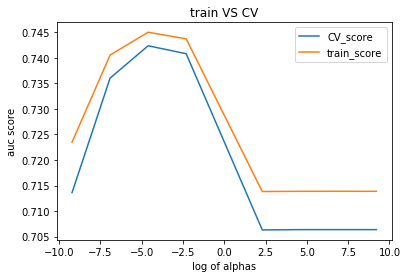

In [32]:
alphas = [10**-4, 10**-3, 10**-2, 10**-1, 10, 10**2, 10**3, 10**4]
log_alphas = np.log(np.asarray(alphas))
plt.plot(log_alphas, cv_scores, label='CV_score')
plt.plot(log_alphas, train_scores, label='train_score')
plt.title('train VS CV')
plt.ylabel('auc score')
plt.xlabel('log of alphas')
plt.legend()
plt.show()

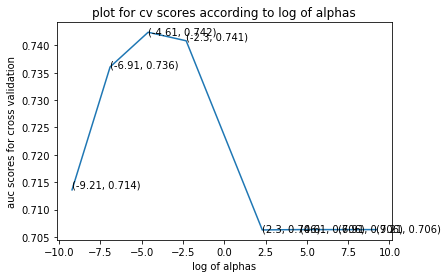

The auc score for each alpha value for cross validation is :  [0.714 0.736 0.742 0.741 0.706 0.706 0.706 0.706]


In [33]:
plt.plot(log_alphas, cv_scores )

plt.title('plot for cv scores according to log of alphas')
for xy in zip(np.round(log_alphas, 2), np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log of alphas')
plt.ylabel('auc scores for cross validation')
plt.show()

print("The auc score for each alpha value for cross validation is : ", np.round(cv_scores,3))

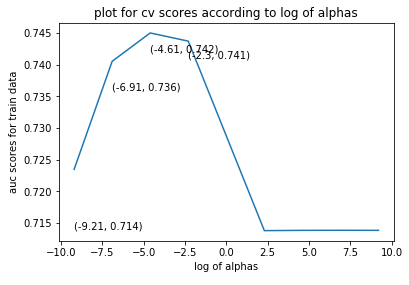

The auc score for each alpha value for train data is :  [0.723 0.741 0.745 0.744 0.714 0.714 0.714 0.714]


In [34]:
plt.plot(log_alphas, train_scores )

plt.title('plot for cv scores according to log of alphas')
for xy in zip(np.round(log_alphas, 2), np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log of alphas')
plt.ylabel('auc scores for train data')
plt.show()

print("The auc score for each alpha value for train data is : ", np.round(train_scores,3))

In [35]:
optimal_alpha_for_cv = alphas[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of alpha for cv is {} and it\'s value is {}'.format(optimal_alpha_for_cv, max(cv_scores)))


The optimal value of alpha for cv is 0.01 and it's value is 0.7423792361710286


In [36]:
optimal_alpha_for_train = alphas[train_scores.index(max(train_scores))]
print('\nThe optimal value of alpha for training is {} and it\'s value is {}'.format(optimal_alpha_for_train, max(train_scores)))


The optimal value of alpha for training is 0.01 and it's value is 0.7450291824118438


In [37]:
x = PrettyTable()
x.field_names = ['alphas for cv', 'cv score', 'alphas for train', 'train score']
for z, y in zip(sorted(cv_scores, reverse=True), sorted(train_scores, reverse=True)):
    x.add_row([alphas[cv_scores.index(z)], z, alphas[train_scores.index(y)], y])
print(x)

+---------------+--------------------+------------------+--------------------+
| alphas for cv |      cv score      | alphas for train |    train score     |
+---------------+--------------------+------------------+--------------------+
|      0.01     | 0.7423792361710286 |       0.01       | 0.7450291824118438 |
|      0.1      | 0.7408176349343305 |       0.1        | 0.7437356363640467 |
|     0.001     | 0.7360414569552295 |      0.001       | 0.7405571380767607 |
|     0.0001    | 0.7136113208225482 |      0.0001      | 0.7234927294371467 |
|      100      | 0.7063545561307641 |       1000       | 0.7138760849270945 |
|      100      | 0.7063545561307641 |       100        | 0.713862037221085  |
|      100      | 0.7063545561307641 |       100        | 0.713862037221085  |
|       10      | 0.7062976344549899 |        10        | 0.713819894103056  |
+---------------+--------------------+------------------+--------------------+


### Based on the above graphs and the table we can choose the optimal value of alpha to be equal to 0.01

In [39]:
SVM_optimal = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=0.01, fit_intercept=False, max_iter=1000, tol=1e-3, class_weight={1: 1, 0: 5.3})

# fitting the model
SVM_optimal.fit(X_train_avgw2v, Y_train)

# predict the response
pred = SVM_optimal.predict(X_test_avgw2v)

# evaluate auc_score
auc_score = roc_auc_score(Y_test, pred)

In [41]:
print('\nThe auc score for test data for alpha = {} is {:2f}'.format(0.01, auc_score))


The auc score for test data for alpha = 0.01 is 0.740302


In [42]:
conf_matrix = confusion_matrix(Y_test, pred)
conf_matrix

array([[1160,   70],
       [4056, 4714]])

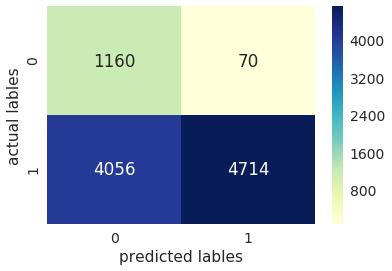

In [43]:
df_cm = pd.DataFrame(conf_matrix, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
plt.xlabel('predicted lables')
plt.ylabel('actual lables')
plt.show()

In [44]:
print(classification_report(Y_test, pred))

             precision    recall  f1-score   support

          0       0.22      0.94      0.36      1230
          1       0.99      0.54      0.70      8770

avg / total       0.89      0.59      0.65     10000



# TF-IDF W2V

In [10]:
i=0
list_of_sent =[]
for sent in X_train['CleanedText'].values:
    filtered_sentence =[]
    sent = clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sent.append(filtered_sentence)


In [11]:
w2v_model=Word2Vec(list_of_sent, min_count=5 ,size=50)

In [12]:
w2v_words = list(w2v_model.wv.vocab)

In [13]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train['CleanedText'].values)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [14]:
tfidf_feat = model.get_feature_names()

X_train_tf = []
row=0;
for sent in tqdm(list_of_sent):  
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_tf.append(sent_vec)
    row += 1

100%|██████████| 40000/40000 [00:56<00:00, 708.52it/s]


In [15]:
X_train_tfidfw2v = np.asarray(X_train_tf)
X_train_tfidfw2v = StandardScaler().fit_transform(X_train_tfidfw2v)
X_train_tfidfw2v.shape

(40000, 50)

In [16]:
train_tfidfw2v = open("train_tfidfw2v.pickle", "wb")
pickle.dump(X_train_tfidfw2v, train_tfidfw2v)
train_tfidfw2v.close()

In [17]:
i=0
list_of_sentence =[]
for sent in X_CV['CleanedText'].values:
    filtered_sentence =[]
    sent = clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sentence.append(filtered_sentence)

In [18]:
X_CV_tfidf = model.transform(X_CV['CleanedText'].values)

In [19]:
tfidf_feat = model.get_feature_names()

X_CV_tf = []
row=0;
for sent in tqdm(list_of_sentence):  
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_CV_tf.append(sent_vec)
    row += 1

100%|██████████| 10000/10000 [00:14<00:00, 686.33it/s]


In [20]:
X_CV_tfidfw2v = np.asarray(X_CV_tf)
X_CV_tfidfw2v = StandardScaler().fit_transform(X_CV_tfidfw2v)
X_CV_tfidfw2v.shape

(10000, 50)

In [21]:
CV_tfidfw2v = open("CV_tfidfw2v.pickle", "wb")
pickle.dump(X_CV_tfidfw2v, CV_tfidfw2v)
CV_tfidfw2v.close()

In [22]:
i=0
list_of_sen =[]
for sent in X_test['CleanedText'].values:
    filtered_sentence =[]
    sent = clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sen.append(filtered_sentence)

In [23]:
X_test_tfidf = model.transform(X_test['CleanedText'].values)


In [24]:
tfidf_feat = model.get_feature_names()

X_test_tf = []
row=0;
for sent in tqdm(list_of_sen):  
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test_tf.append(sent_vec)
    row += 1

100%|██████████| 10000/10000 [00:13<00:00, 746.79it/s]


In [25]:
X_test_tfidfw2v = np.asarray(X_test_tf)
X_test_tfidfw2v = StandardScaler().fit_transform(X_test_tfidfw2v)
X_test_tfidfw2v.shape

(10000, 50)

In [26]:
test_tfidfw2v = open("test_tfidfw2v.pickle", "wb")
pickle.dump(X_test_tfidfw2v, test_tfidfw2v)
test_tfidfw2v.close()

## Linear SVM on TF-IDF W2V

In [27]:
tuned_parameters = [{'alpha' : [10**-4, 10**-3, 10**-2, 10**-1, 10, 10**2, 10**3, 10**4], 'penalty' : ['l1', 'l2']}]
model = GridSearchCV(linear_model.SGDClassifier(loss='hinge', fit_intercept=False, max_iter=1000, tol=1e-3, class_weight={1: 1, 0: 5.3}), tuned_parameters, scoring = 'roc_auc')
model.fit(X_train_tfidfw2v, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight={1: 1, 0: 5.3},
       epsilon=0.1, eta0=0.0, fit_intercept=False, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=0.001, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'alpha': [0.0001, 0.001, 0.01, 0.1, 10, 100, 1000, 10000], 'penalty': ['l1', 'l2']}],
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

### From above it can be seen that best penalty would be l2, thus using l2 penalty now we will get the train and CV scores

In [28]:
def scores(X, Y):
    alphas = [10**-4, 10**-3, 10**-2, 10**-1, 10, 10**2, 10**3, 10**4]
    scores = []
    for alpha in alphas:
            clf = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=alpha, fit_intercept=False, max_iter=1000, tol=1e-3, class_weight={1: 1, 0: 5.3})
            clf_sigmoid = CalibratedClassifierCV(clf, cv=2, method='sigmoid')
            clf_sigmoid.fit(X_train_bow, Y_train)
            pred = clf_sigmoid.predict(X)
            auc = roc_auc_score(Y, pred)
            scores.append(auc)
    return scores

In [29]:
cv_scores = scores(X_CV_tfidfw2v, Y_CV)

In [30]:
train_scores = scores(X_train_tfidfw2v, Y_train)

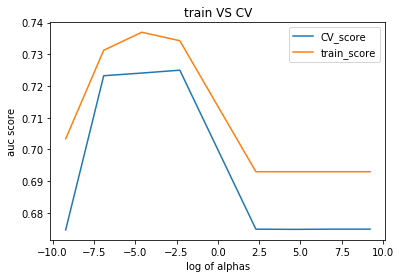

In [31]:
alphas = [10**-4, 10**-3, 10**-2, 10**-1, 10, 10**2, 10**3, 10**4]
log_alphas = np.log(np.asarray(alphas))
plt.plot(log_alphas, cv_scores, label='CV_score')
plt.plot(log_alphas, train_scores, label='train_score')
plt.title('train VS CV')
plt.ylabel('auc score')
plt.xlabel('log of alphas')
plt.legend()
plt.show()

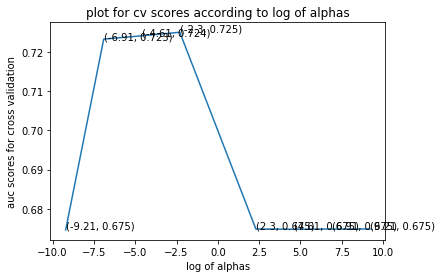

The auc score for each alpha value for cross validation is :  [0.675 0.723 0.724 0.725 0.675 0.675 0.675 0.675]


In [32]:
plt.plot(log_alphas, cv_scores )

plt.title('plot for cv scores according to log of alphas')
for xy in zip(np.round(log_alphas, 2), np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log of alphas')
plt.ylabel('auc scores for cross validation')
plt.show()

print("The auc score for each alpha value for cross validation is : ", np.round(cv_scores,3))

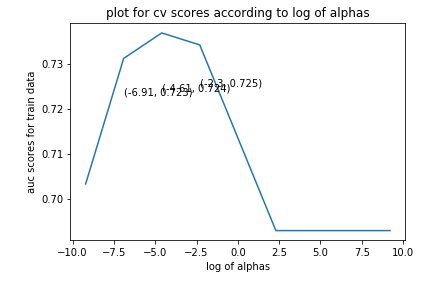

The auc score for each alpha value for train data is :  [0.703 0.731 0.737 0.734 0.693 0.693 0.693 0.693]


In [33]:
plt.plot(log_alphas, train_scores )

plt.title('plot for cv scores according to log of alphas')
for xy in zip(np.round(log_alphas, 2), np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log of alphas')
plt.ylabel('auc scores for train data')
plt.show()

print("The auc score for each alpha value for train data is : ", np.round(train_scores,3))

In [34]:
optimal_alpha_for_cv = alphas[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of alpha for cv is {} and it\'s value is {}'.format(optimal_alpha_for_cv, max(cv_scores)))


The optimal value of alpha for cv is 0.1 and it's value is 0.7249709399865785


In [35]:
optimal_alpha_for_train = alphas[train_scores.index(max(train_scores))]
print('\nThe optimal value of alpha for training is {} and it\'s value is {}'.format(optimal_alpha_for_train, max(train_scores)))


The optimal value of alpha for training is 0.01 and it's value is 0.7369315899540472


In [36]:
x = PrettyTable()
x.field_names = ['alphas for cv', 'cv score', 'alphas for train', 'train score']
for z, y in zip(sorted(cv_scores, reverse=True), sorted(train_scores, reverse=True)):
    x.add_row([alphas[cv_scores.index(z)], z, alphas[train_scores.index(y)], y])
print(x)

+---------------+--------------------+------------------+--------------------+
| alphas for cv |      cv score      | alphas for train |    train score     |
+---------------+--------------------+------------------+--------------------+
|      0.1      | 0.7249709399865785 |       0.01       | 0.7369315899540472 |
|      0.01     | 0.7240661849295369 |       0.1        | 0.7342561633839948 |
|     0.001     | 0.7232243433036142 |      0.001       | 0.7312578053303646 |
|       10      | 0.6748506554980347 |      0.0001      | 0.7033335317926427 |
|       10      | 0.6748506554980347 |        10        | 0.6929592196210197 |
|       10      | 0.6748506554980347 |        10        | 0.6929592196210197 |
|      100      | 0.6747937338222605 |        10        | 0.6929592196210197 |
|     0.0001    | 0.6746177260090117 |        10        | 0.6929592196210197 |
+---------------+--------------------+------------------+--------------------+


### Based on the above graphs and the table we can choose the optimal value of alpha to be equal to 0.01

In [37]:
SVM_optimal = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=0.01, fit_intercept=False, max_iter=1000, tol=1e-3, class_weight={1: 1, 0: 5.3})

# fitting the model
SVM_optimal.fit(X_train_tfidfw2v, Y_train)

# predict the response
pred = SVM_optimal.predict(X_test_tfidfw2v)

# evaluate auc_score
auc_score = roc_auc_score(Y_test, pred)

In [39]:
print('\nThe auc score for test data for alpha = {} is {:2f}'.format(0.01, auc_score))


The auc score for test data for alpha = 0.01 is 0.726691


In [40]:
conf_matrix = confusion_matrix(Y_test, pred)
conf_matrix

array([[1139,   91],
       [4145, 4625]])

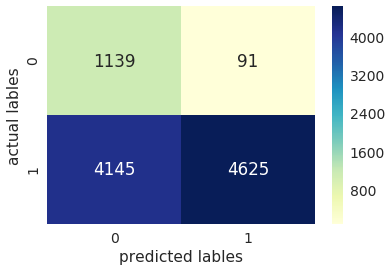

In [41]:
df_cm = pd.DataFrame(conf_matrix, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
plt.xlabel('predicted lables')
plt.ylabel('actual lables')
plt.show()

In [42]:
print(classification_report(Y_test, pred))

             precision    recall  f1-score   support

          0       0.22      0.93      0.35      1230
          1       0.98      0.53      0.69      8770

avg / total       0.89      0.58      0.64     10000



# Comparison of all the models.

In [3]:
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyperparameter", "AUC-Score on the test data"]
x.add_row(['BOW', 'Linear SVM', 0.01, '0.8207'])
x.add_row(['TF-IDF', 'Linear SVM', 0.001, '0.8014'])
x.add_row(['Average W2V', 'Linear SVM',0.01, '0.7403'])
x.add_row(['TF-IDF Weighted W2V', 'Linear SVM', 0.01, '0.7266'])
print(x)

+---------------------+------------+----------------+----------------------------+
|      Vectorizer     |   Model    | Hyperparameter | AUC-Score on the test data |
+---------------------+------------+----------------+----------------------------+
|         BOW         | Linear SVM |      0.01      |           0.8207           |
|        TF-IDF       | Linear SVM |     0.001      |           0.8014           |
|     Average W2V     | Linear SVM |      0.01      |           0.7403           |
| TF-IDF Weighted W2V | Linear SVM |      0.01      |           0.7266           |
+---------------------+------------+----------------+----------------------------+


## Thus, from the above table we can see that the model with BOW vectorizer performed better.

# 2:-RBF Kernel SVM

In [4]:
#Taking top 30k values for the RBF kernel implementation
final = final.iloc[0: 30000,:]

In [5]:
#Saving the score values in a diffrent list and processing it for train, cv and test data
scores = final['Score'].get_values()
li = lambda x: 1 if x=='positive'  else 0
final_scores = []
for i in range(0,30000):
    final_scores.append(li(scores[i]))
final_scores = np.asarray(final_scores)
final_scores.shape

(30000,)

# Dividing the whole data into train, cross-validation and test sets

In [6]:
#train data
X_train = final[0: 20000]
Y_train = final_scores[0: 20000]
print(X_train.shape)
print(Y_train.shape)

(20000, 12)
(20000,)


In [7]:
#CV data
X_CV = final[20000: 25000]
Y_CV = final_scores[20000: 25000]
print(X_CV.shape)
print(Y_CV.shape)

(5000, 12)
(5000,)


In [8]:
#test data
X_test = final[25000: ]
Y_test = final_scores[25000: ]
print(X_test.shape)
print(Y_test.shape)

(5000, 12)
(5000,)


# BOW

In [8]:
count_vect = CountVectorizer(max_features=500, min_df=10)
X_train_bow = count_vect.fit_transform(X_train['CleanedText'].values)
X_train_bow.shape

(20000, 500)

In [9]:
train_bow = open("train_bow.pickle", "wb")
pickle.dump(X_train_bow, train_bow)
train_bow.close()

In [10]:
X_CV_bow = count_vect.transform(X_CV['CleanedText'].values)
X_CV_bow.shape

(5000, 500)

In [11]:
CV_bow = open("CV_bow.pickle", "wb")
pickle.dump(X_CV_bow, CV_bow)
CV_bow.close()

In [12]:
X_test_bow = count_vect.transform(X_test['CleanedText'].values)
X_test_bow.shape

(5000, 500)

In [13]:
test_bow = open("test_bow.pickle", "wb")
pickle.dump(X_test_bow, test_bow)
test_bow.close()

## RBF kernel SVM on BOW

In [19]:
def scores(X, Y):
    C = [10**-4, 10**-3, 10**-2, 10**-1, 10, 10**2]
    scores = []
    for c in tqdm(C):
            clf = SVC(C=c, kernel='rbf')
            clf.fit(X_train_bow, Y_train)
            pred = clf.predict(X)
            auc = roc_auc_score(Y, pred)
            scores.append(auc)
    return scores

In [20]:
cv_scores = scores(X_CV_bow, Y_CV)


100%|██████████| 6/6 [02:51<00:00, 28.53s/it]


In [21]:
train_scores = scores(X_train_bow, Y_train)


100%|██████████| 6/6 [03:55<00:00, 39.28s/it]


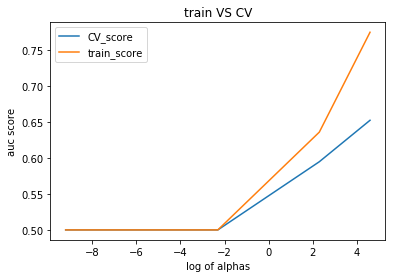

In [22]:
C = [10**-4, 10**-3, 10**-2, 10**-1, 10, 10**2]
log_alphas = np.log(np.asarray(C))
plt.plot(log_alphas, cv_scores, label='CV_score')
plt.plot(log_alphas, train_scores, label='train_score')
plt.title('train VS CV')
plt.ylabel('auc score')
plt.xlabel('log of alphas')
plt.legend()
plt.show()

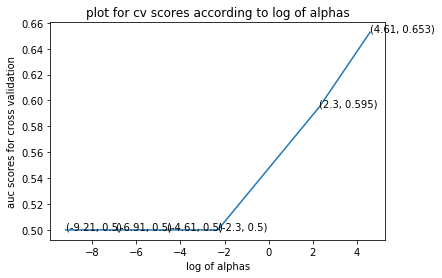

The auc score for each alpha value for cross validation is :  [0.5   0.5   0.5   0.5   0.595 0.653]


In [23]:
plt.plot(log_alphas, cv_scores )

plt.title('plot for cv scores according to log of alphas')
for xy in zip(np.round(log_alphas, 2), np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log of alphas')
plt.ylabel('auc scores for cross validation')
plt.show()

print("The auc score for each alpha value for cross validation is : ", np.round(cv_scores,3))

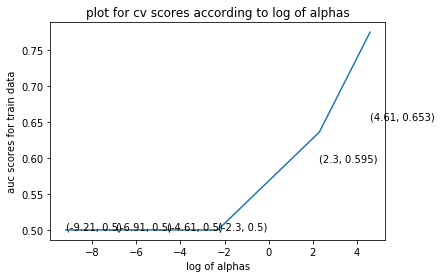

The auc score for each alpha value for train data is :  [0.5   0.5   0.5   0.5   0.636 0.775]


In [24]:
plt.plot(log_alphas, train_scores )

plt.title('plot for cv scores according to log of alphas')
for xy in zip(np.round(log_alphas, 2), np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log of alphas')
plt.ylabel('auc scores for train data')
plt.show()

print("The auc score for each alpha value for train data is : ", np.round(train_scores,3))

In [26]:
optimal_C_for_cv = C[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of C for cv is {} and it\'s value is {}'.format(optimal_C_for_cv, max(cv_scores)))


The optimal value of C for cv is 100 and it's value is 0.6526935985626143


In [28]:
optimal_C_for_train = C[train_scores.index(max(train_scores))]
print('\nThe optimal value of C for training is {} and it\'s value is {}'.format(optimal_C_for_train, max(train_scores)))


The optimal value of C for training is 100 and it's value is 0.7752820864389703


In [29]:
x = PrettyTable()
x.field_names = ['C for cv', 'cv score', 'C for train', 'train score']
for z, y in zip(sorted(cv_scores, reverse=True), sorted(train_scores, reverse=True)):
    x.add_row([C[cv_scores.index(z)], z, C[train_scores.index(y)], y])
print(x)

+----------+--------------------+-------------+--------------------+
| C for cv |      cv score      | C for train |    train score     |
+----------+--------------------+-------------+--------------------+
|   100    | 0.6526935985626143 |     100     | 0.7752820864389703 |
|    10    | 0.5949385749768543 |      10     | 0.636165701133651  |
|  0.0001  |        0.5         |    0.0001   |        0.5         |
|  0.0001  |        0.5         |    0.0001   |        0.5         |
|  0.0001  |        0.5         |    0.0001   |        0.5         |
|  0.0001  |        0.5         |    0.0001   |        0.5         |
+----------+--------------------+-------------+--------------------+


### Based on the above graphs and the table we can choose the optimal value of C to be equal to 100

In [30]:
SVM_optimal = SVC(C=100, kernel='rbf')

# fitting the model
SVM_optimal.fit(X_train_bow, Y_train)

# predict the response
pred = SVM_optimal.predict(X_test_bow)

# evaluate auc_score
auc_score = roc_auc_score(Y_test, pred)

In [31]:
print('\nThe auc score for test data for C = {} is {:2f}'.format(100, auc_score))


The auc score for test data for C = 100 is 0.665803


In [32]:
conf_matrix = confusion_matrix(Y_test, pred)
conf_matrix

array([[ 171,  313],
       [  98, 4418]])

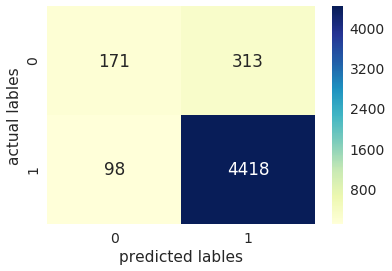

In [33]:
df_cm = pd.DataFrame(conf_matrix, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
plt.xlabel('predicted lables')
plt.ylabel('actual lables')
plt.show()

In [34]:
print(classification_report(Y_test, pred))

             precision    recall  f1-score   support

          0       0.64      0.35      0.45       484
          1       0.93      0.98      0.96      4516

avg / total       0.90      0.92      0.91      5000



# TF-IDF

In [9]:
tf_idf_vect = TfidfVectorizer(max_features=500, min_df=10)
X_train_tfidf = tf_idf_vect.fit_transform(X_train['CleanedText'].values)
X_train_tfidf.shape

(20000, 500)

In [10]:
X_CV_tfidf = tf_idf_vect.transform(X_CV['CleanedText'].values)
X_CV_tfidf.shape

(5000, 500)

In [11]:
X_test_tfidf = tf_idf_vect.transform(X_test['CleanedText'].values)
X_test_tfidf.shape

(5000, 500)

## RBF kernel SVM on TF-IDF

In [12]:
def scores(X, Y):
    C = [10**-4, 10**-3, 10**-2, 10**-1, 10, 10**2]
    scores = []
    for c in tqdm(C):
            clf = SVC(C=c, kernel='rbf')
            clf.fit(X_train_tfidf, Y_train)
            pred = clf.predict(X)
            auc = roc_auc_score(Y, pred)
            scores.append(auc)
    return scores

In [13]:
cv_scores = scores(X_CV_tfidf, Y_CV)

100%|██████████| 6/6 [02:38<00:00, 26.35s/it]


In [14]:
train_scores = scores(X_train_tfidf, Y_train)

100%|██████████| 6/6 [03:57<00:00, 39.61s/it]


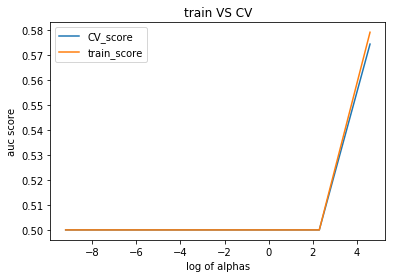

In [15]:
C = [10**-4, 10**-3, 10**-2, 10**-1, 10, 10**2]
log_alphas = np.log(np.asarray(C))
plt.plot(log_alphas, cv_scores, label='CV_score')
plt.plot(log_alphas, train_scores, label='train_score')
plt.title('train VS CV')
plt.ylabel('auc score')
plt.xlabel('log of alphas')
plt.legend()
plt.show()

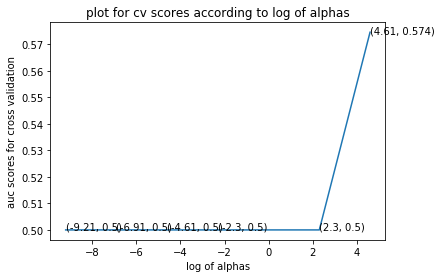

The auc score for each alpha value for cross validation is :  [0.5   0.5   0.5   0.5   0.5   0.574]


In [16]:
plt.plot(log_alphas, cv_scores )

plt.title('plot for cv scores according to log of alphas')
for xy in zip(np.round(log_alphas, 2), np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log of alphas')
plt.ylabel('auc scores for cross validation')
plt.show()

print("The auc score for each alpha value for cross validation is : ", np.round(cv_scores,3))

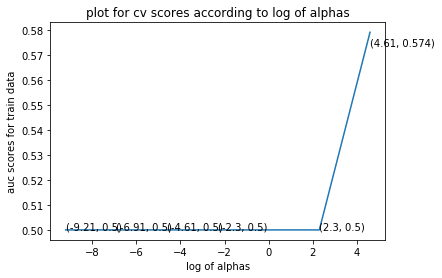

The auc score for each alpha value for train data is :  [0.5   0.5   0.5   0.5   0.5   0.579]


In [17]:
plt.plot(log_alphas, train_scores )

plt.title('plot for cv scores according to log of alphas')
for xy in zip(np.round(log_alphas, 2), np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log of alphas')
plt.ylabel('auc scores for train data')
plt.show()

print("The auc score for each alpha value for train data is : ", np.round(train_scores,3))

In [18]:
optimal_C_for_cv = C[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of C for cv is {} and it\'s value is {}'.format(optimal_C_for_cv, max(cv_scores)))


The optimal value of C for cv is 100 and it's value is 0.5744868719373664


In [19]:
optimal_C_for_train = C[train_scores.index(max(train_scores))]
print('\nThe optimal value of C for training is {} and it\'s value is {}'.format(optimal_C_for_train, max(train_scores)))


The optimal value of C for training is 100 and it's value is 0.5792345788497641


In [20]:
x = PrettyTable()
x.field_names = ['C for cv', 'cv score', 'C for train', 'train score']
for z, y in zip(sorted(cv_scores, reverse=True), sorted(train_scores, reverse=True)):
    x.add_row([C[cv_scores.index(z)], z, C[train_scores.index(y)], y])
print(x)

+----------+--------------------+-------------+--------------------+
| C for cv |      cv score      | C for train |    train score     |
+----------+--------------------+-------------+--------------------+
|   100    | 0.5744868719373664 |     100     | 0.5792345788497641 |
|  0.0001  |        0.5         |    0.0001   |        0.5         |
|  0.0001  |        0.5         |    0.0001   |        0.5         |
|  0.0001  |        0.5         |    0.0001   |        0.5         |
|  0.0001  |        0.5         |    0.0001   |        0.5         |
|  0.0001  |        0.5         |    0.0001   |        0.5         |
+----------+--------------------+-------------+--------------------+


### Based on the above graphs and the table we can choose the optimal value of C to be equal to 100

In [22]:
SVM_optimal = SVC(C=100, kernel='rbf')

# fitting the model
SVM_optimal.fit(X_train_tfidf, Y_train)

# predict the response
pred = SVM_optimal.predict(X_test_tfidf)

# evaluate auc_score
auc_score = roc_auc_score(Y_test, pred)

In [23]:
print('\nThe auc score for test data for C = {} is {:2f}'.format(100, auc_score))


The auc score for test data for C = 100 is 0.571318


In [24]:
conf_matrix = confusion_matrix(Y_test, pred)
conf_matrix

array([[  70,  414],
       [   9, 4507]])

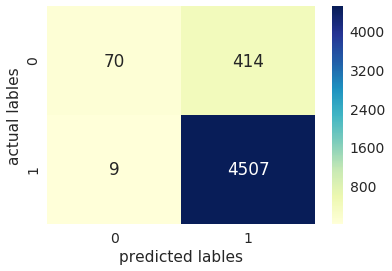

In [25]:
df_cm = pd.DataFrame(conf_matrix, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
plt.xlabel('predicted lables')
plt.ylabel('actual lables')
plt.show()

In [26]:
print(classification_report(Y_test, pred))

             precision    recall  f1-score   support

          0       0.89      0.14      0.25       484
          1       0.92      1.00      0.96      4516

avg / total       0.91      0.92      0.89      5000



# W2V

In [9]:
i=0
list_of_sent =[]
for sent in X_train['Text'].values:
    filtered_sentence =[]
    sent = clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sent.append(filtered_sentence)

In [10]:
w2v_model=Word2Vec(list_of_sent, min_count=5 ,size=50)

In [11]:
w2v_words = list(w2v_model.wv.vocab)

# Average W2V

In [12]:
X_train_avgw2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_train_avgw2v.append(sent_vec)
print(len(X_train_avgw2v))
print(len(X_train_avgw2v[0]))

100%|██████████| 20000/20000 [00:39<00:00, 507.37it/s]

20000
50


In [13]:
X_train_avgw2v = np.asarray(X_train_avgw2v)

In [14]:
X_train_avgw2v = StandardScaler().fit_transform(X_train_avgw2v)

In [15]:
train_w2v = open("train_w2v.pickle", "wb")
pickle.dump(X_train_avgw2v, train_w2v)
train_w2v.close()

In [16]:
i=0
list_of_sentence =[]
for sent in X_CV['Text'].values:
    filtered_sentence =[]
    sent = clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sentence.append(filtered_sentence)

In [17]:
X_CV_avgw2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_CV_avgw2v.append(sent_vec)
print(len(X_CV_avgw2v))
print(len(X_CV_avgw2v[0]))

100%|██████████| 5000/5000 [00:09<00:00, 533.06it/s]

5000
50


In [18]:
X_CV_avgw2v = np.asarray(X_CV_avgw2v)
X_CV_avgw2v = StandardScaler().fit_transform(X_CV_avgw2v)
X_CV_avgw2v.shape

(5000, 50)

In [19]:
CV_w2v = open("CV_w2v.pickle", "wb")
pickle.dump(X_CV_avgw2v, CV_w2v)
CV_w2v.close()

In [20]:
i=0
list_of_sen =[]
for sent in X_test['Text'].values:
    filtered_sentence =[]
    sent = clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sen.append(filtered_sentence)

In [21]:
X_test_avgw2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sen): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_avgw2v.append(sent_vec)
print(len(X_test_avgw2v))
print(len(X_test_avgw2v[0]))

100%|██████████| 5000/5000 [00:11<00:00, 452.98it/s]

5000
50


In [22]:
X_test_avgw2v = np.asarray(X_test_avgw2v)
X_test_avgw2v = StandardScaler().fit_transform(X_test_avgw2v)
X_test_avgw2v.shape

(5000, 50)

In [23]:
test_w2v = open("test_w2v.pickle", "wb")
pickle.dump(X_test_avgw2v, test_w2v)
test_w2v.close()

## RBF kernel SVM on Average W2V

In [24]:
def scores(X, Y):
    C = [10**-4, 10**-3, 10**-2, 10**-1, 10, 10**2]
    scores = []
    for c in tqdm(C):
            clf = SVC(C=c, kernel='rbf')
            clf.fit(X_train_avgw2v, Y_train)
            pred = clf.predict(X)
            auc = roc_auc_score(Y, pred)
            scores.append(auc)
    return scores

In [25]:
cv_scores = scores(X_CV_avgw2v, Y_CV)

100%|██████████| 6/6 [03:00<00:00, 30.04s/it]


In [26]:
train_scores = scores(X_train_avgw2v, Y_train)

100%|██████████| 6/6 [03:37<00:00, 36.17s/it]


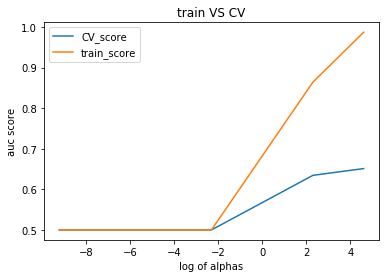

In [27]:
C = [10**-4, 10**-3, 10**-2, 10**-1, 10, 10**2]
log_alphas = np.log(np.asarray(C))
plt.plot(log_alphas, cv_scores, label='CV_score')
plt.plot(log_alphas, train_scores, label='train_score')
plt.title('train VS CV')
plt.ylabel('auc score')
plt.xlabel('log of alphas')
plt.legend()
plt.show()

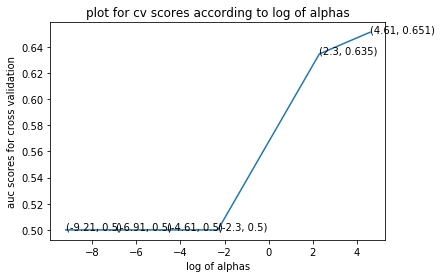

The auc score for each alpha value for cross validation is :  [0.5   0.5   0.5   0.5   0.635 0.651]


In [28]:
plt.plot(log_alphas, cv_scores )

plt.title('plot for cv scores according to log of alphas')
for xy in zip(np.round(log_alphas, 2), np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log of alphas')
plt.ylabel('auc scores for cross validation')
plt.show()

print("The auc score for each alpha value for cross validation is : ", np.round(cv_scores,3))

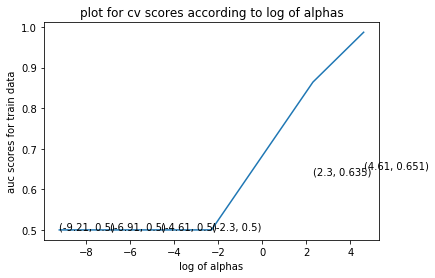

The auc score for each alpha value for train data is :  [0.5   0.5   0.5   0.5   0.864 0.987]


In [29]:
plt.plot(log_alphas, train_scores )

plt.title('plot for cv scores according to log of alphas')
for xy in zip(np.round(log_alphas, 2), np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log of alphas')
plt.ylabel('auc scores for train data')
plt.show()

print("The auc score for each alpha value for train data is : ", np.round(train_scores,3))

In [30]:
optimal_C_for_cv = C[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of C for cv is {} and it\'s value is {}'.format(optimal_C_for_cv, max(cv_scores)))


The optimal value of C for cv is 100 and it's value is 0.6511946340302535


In [31]:
optimal_C_for_train = C[train_scores.index(max(train_scores))]
print('\nThe optimal value of C for training is {} and it\'s value is {}'.format(optimal_C_for_train, max(train_scores)))


The optimal value of C for training is 100 and it's value is 0.9872944081451372


In [32]:
x = PrettyTable()
x.field_names = ['C for cv', 'cv score', 'C for train', 'train score']
for z, y in zip(sorted(cv_scores, reverse=True), sorted(train_scores, reverse=True)):
    x.add_row([C[cv_scores.index(z)], z, C[train_scores.index(y)], y])
print(x)

+----------+--------------------+-------------+--------------------+
| C for cv |      cv score      | C for train |    train score     |
+----------+--------------------+-------------+--------------------+
|   100    | 0.6511946340302535 |     100     | 0.9872944081451372 |
|    10    | 0.6345800231281055 |      10     | 0.8643951223887543 |
|  0.0001  |        0.5         |    0.0001   |        0.5         |
|  0.0001  |        0.5         |    0.0001   |        0.5         |
|  0.0001  |        0.5         |    0.0001   |        0.5         |
|  0.0001  |        0.5         |    0.0001   |        0.5         |
+----------+--------------------+-------------+--------------------+


### Based on the above graphs and the table we can choose the optimal value of C to be equal to 100

In [34]:
SVM_optimal = SVC(C=100, kernel='rbf')

# fitting the model
SVM_optimal.fit(X_train_avgw2v, Y_train)

# predict the response
pred = SVM_optimal.predict(X_test_avgw2v)

# evaluate auc_score
auc_score = roc_auc_score(Y_test, pred)

In [35]:
print('\nThe auc score for test data for C = {} is {:2f}'.format(100, auc_score))


The auc score for test data for C = 100 is 0.662623


In [36]:
conf_matrix = confusion_matrix(Y_test, pred)
conf_matrix

array([[ 190,  294],
       [ 304, 4212]])

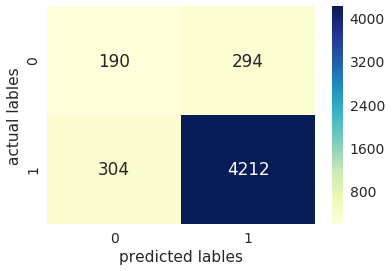

In [37]:
df_cm = pd.DataFrame(conf_matrix, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
plt.xlabel('predicted lables')
plt.ylabel('actual lables')
plt.show()

In [38]:
print(classification_report(Y_test, pred))

             precision    recall  f1-score   support

          0       0.38      0.39      0.39       484
          1       0.93      0.93      0.93      4516

avg / total       0.88      0.88      0.88      5000



## TF-IDF W2V

In [9]:
i=0
list_of_sent =[]
for sent in X_train['CleanedText'].values:
    filtered_sentence =[]
    sent = clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sent.append(filtered_sentence)


In [10]:
w2v_model=Word2Vec(list_of_sent, min_count=5 ,size=50)

In [11]:
w2v_words = list(w2v_model.wv.vocab)

In [15]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train['CleanedText'].values)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [16]:
tfidf_feat = model.get_feature_names()

X_train_tf = []
row=0;
for sent in tqdm(list_of_sent):  
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_tf.append(sent_vec)
    row += 1

100%|██████████| 20000/20000 [00:24<00:00, 831.56it/s]


In [17]:
X_train_tfidfw2v = np.asarray(X_train_tf)
X_train_tfidfw2v = StandardScaler().fit_transform(X_train_tfidfw2v)
X_train_tfidfw2v.shape

(20000, 50)

In [18]:
train_tfidfw2v = open("train_tfidfw2v.pickle", "wb")
pickle.dump(X_train_tfidfw2v, train_tfidfw2v)
train_tfidfw2v.close()

In [19]:
i=0
list_of_sentence =[]
for sent in X_CV['CleanedText'].values:
    filtered_sentence =[]
    sent = clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sentence.append(filtered_sentence)

In [21]:
X_CV_tfidf = model.transform(X_CV['CleanedText'].values)

In [22]:
tfidf_feat = model.get_feature_names()

X_CV_tf = []
row=0;
for sent in tqdm(list_of_sentence):  
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_CV_tf.append(sent_vec)
    row += 1

100%|██████████| 5000/5000 [00:06<00:00, 810.40it/s]


In [23]:
X_CV_tfidfw2v = np.asarray(X_CV_tf)
X_CV_tfidfw2v = StandardScaler().fit_transform(X_CV_tfidfw2v)
X_CV_tfidfw2v.shape

(5000, 50)

In [24]:
CV_tfidfw2v = open("CV_tfidfw2v.pickle", "wb")
pickle.dump(X_CV_tfidfw2v, CV_tfidfw2v)
CV_tfidfw2v.close()

In [25]:
i=0
list_of_sen =[]
for sent in X_test['CleanedText'].values:
    filtered_sentence =[]
    sent = clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sen.append(filtered_sentence)

In [26]:
X_test_tfidf = model.transform(X_test['CleanedText'].values)

In [27]:
tfidf_feat = model.get_feature_names()

X_test_tf = []
row=0;
for sent in tqdm(list_of_sen):  
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test_tf.append(sent_vec)
    row += 1

100%|██████████| 5000/5000 [00:06<00:00, 730.04it/s]


In [28]:
X_test_tfidfw2v = np.asarray(X_test_tf)
X_test_tfidfw2v = StandardScaler().fit_transform(X_test_tfidfw2v)
X_test_tfidfw2v.shape

(5000, 50)

In [29]:
test_tfidfw2v = open("test_tfidfw2v.pickle", "wb")
pickle.dump(X_test_tfidfw2v, test_tfidfw2v)
test_tfidfw2v.close()

## RBF Kernel SVM on TF-IDF W2V

In [30]:
def scores(X, Y):
    C = [10**-4, 10**-3, 10**-2, 10**-1, 10, 10**2]
    scores = []
    for c in tqdm(C):
            clf = SVC(C=c, kernel='rbf')
            clf.fit(X_train_tfidfw2v, Y_train)
            pred = clf.predict(X)
            auc = roc_auc_score(Y, pred)
            scores.append(auc)
    return scores

In [31]:
cv_scores = scores(X_CV_tfidfw2v, Y_CV)

100%|██████████| 6/6 [02:35<00:00, 25.99s/it]


In [32]:
train_scores = scores(X_train_tfidfw2v, Y_train)

100%|██████████| 6/6 [03:13<00:00, 32.20s/it]


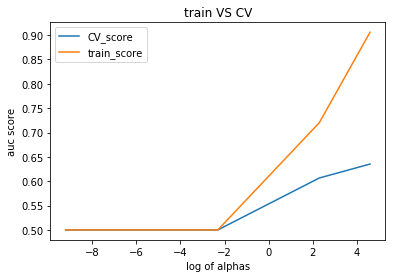

In [33]:
C = [10**-4, 10**-3, 10**-2, 10**-1, 10, 10**2]
log_alphas = np.log(np.asarray(C))
plt.plot(log_alphas, cv_scores, label='CV_score')
plt.plot(log_alphas, train_scores, label='train_score')
plt.title('train VS CV')
plt.ylabel('auc score')
plt.xlabel('log of alphas')
plt.legend()
plt.show()

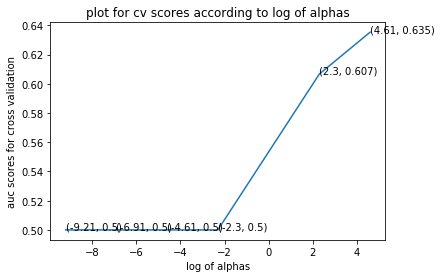

The auc score for each alpha value for cross validation is :  [0.5   0.5   0.5   0.5   0.607 0.635]


In [34]:
plt.plot(log_alphas, cv_scores )

plt.title('plot for cv scores according to log of alphas')
for xy in zip(np.round(log_alphas, 2), np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log of alphas')
plt.ylabel('auc scores for cross validation')
plt.show()

print("The auc score for each alpha value for cross validation is : ", np.round(cv_scores,3))

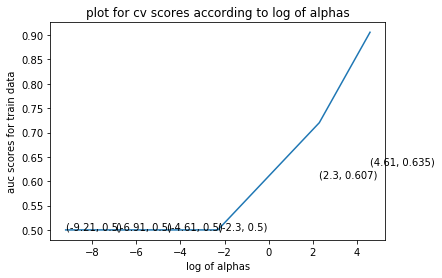

The auc score for each alpha value for train data is :  [0.5   0.5   0.5   0.5   0.72  0.906]


In [35]:
plt.plot(log_alphas, train_scores )

plt.title('plot for cv scores according to log of alphas')
for xy in zip(np.round(log_alphas, 2), np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log of alphas')
plt.ylabel('auc scores for train data')
plt.show()

print("The auc score for each alpha value for train data is : ", np.round(train_scores,3))

In [36]:
optimal_C_for_cv = C[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of C for cv is {} and it\'s value is {}'.format(optimal_C_for_cv, max(cv_scores)))


The optimal value of C for cv is 100 and it's value is 0.6352688418303221


In [37]:
optimal_C_for_train = C[train_scores.index(max(train_scores))]
print('\nThe optimal value of C for training is {} and it\'s value is {}'.format(optimal_C_for_train, max(train_scores)))


The optimal value of C for training is 100 and it's value is 0.9059617599588622


In [38]:
x = PrettyTable()
x.field_names = ['C for cv', 'cv score', 'C for train', 'train score']
for z, y in zip(sorted(cv_scores, reverse=True), sorted(train_scores, reverse=True)):
    x.add_row([C[cv_scores.index(z)], z, C[train_scores.index(y)], y])
print(x)

+----------+--------------------+-------------+--------------------+
| C for cv |      cv score      | C for train |    train score     |
+----------+--------------------+-------------+--------------------+
|   100    | 0.6352688418303221 |     100     | 0.9059617599588622 |
|    10    | 0.6066299919881251 |      10     | 0.720190838950084  |
|  0.0001  |        0.5         |    0.0001   |        0.5         |
|  0.0001  |        0.5         |    0.0001   |        0.5         |
|  0.0001  |        0.5         |    0.0001   |        0.5         |
|  0.0001  |        0.5         |    0.0001   |        0.5         |
+----------+--------------------+-------------+--------------------+


### Based on the above graphs and the table we can choose the optimal value of C to be equal to 100

In [39]:
SVM_optimal = SVC(C=100, kernel='rbf')

# fitting the model
SVM_optimal.fit(X_train_tfidfw2v, Y_train)

# predict the response
pred = SVM_optimal.predict(X_test_tfidfw2v)

# evaluate auc_score
auc_score = roc_auc_score(Y_test, pred)

In [40]:
print('\nThe auc score for test data for C = {} is {:2f}'.format(100, auc_score))


The auc score for test data for C = 100 is 0.667864


In [41]:
conf_matrix = confusion_matrix(Y_test, pred)
conf_matrix

array([[ 188,  296],
       [ 238, 4278]])

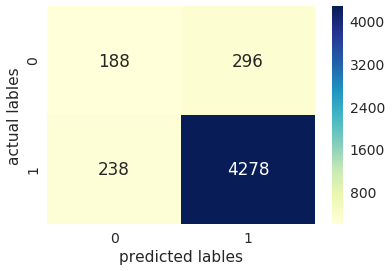

In [42]:
df_cm = pd.DataFrame(conf_matrix, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
plt.xlabel('predicted lables')
plt.ylabel('actual lables')
plt.show()

In [43]:
print(classification_report(Y_test, pred))

             precision    recall  f1-score   support

          0       0.44      0.39      0.41       484
          1       0.94      0.95      0.94      4516

avg / total       0.89      0.89      0.89      5000



# Comparison of all the models.

In [44]:
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyperparameter", "AUC-Score on the test data"]
x.add_row(['BOW', 'RBF SVM', 100, '0.6658'])
x.add_row(['TF-IDF', 'RBF SVM', 100, '0.5713'])
x.add_row(['Average W2V', 'RBF SVM',100, '0.6626'])
x.add_row(['TF-IDF Weighted W2V', 'RBF SVM', 100, '0.6678'])
print(x)

+---------------------+---------+----------------+----------------------------+
|      Vectorizer     |  Model  | Hyperparameter | AUC-Score on the test data |
+---------------------+---------+----------------+----------------------------+
|         BOW         | RBF SVM |      100       |           0.6658           |
|        TF-IDF       | RBF SVM |      100       |           0.5713           |
|     Average W2V     | RBF SVM |      100       |           0.6626           |
| TF-IDF Weighted W2V | RBF SVM |      100       |           0.6678           |
+---------------------+---------+----------------+----------------------------+


## Thus, from the above table we can see that the model with TF-IDF weighted W2V vectorizer performed better.